In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from sklearn.utils import resample
from sklearn.metrics import accuracy_score  
from scipy import stats

# Conceptual

## 1.
### Derivar la fórmula (5.6)

Queremos minimizar la varianza de la combinación lineal:


$
Z(\alpha) = \alpha X + (1 - \alpha) Y.
$


Usando propiedades básicas de la varianza, tenemos:


$
\operatorname{Var}(Z(\alpha))
= \operatorname{Var}(\alpha X + (1-\alpha)Y)
= \alpha^2 \operatorname{Var}(X)
+ (1-\alpha)^2 \operatorname{Var}(Y)
+ 2\alpha(1-\alpha)\operatorname{Cov}(X,Y).
$

Para abreviar:

$
\sigma_X^2 = \operatorname{Var}(X), \qquad
\sigma_Y^2 = \operatorname{Var}(Y), \qquad
\sigma_{XY} = \operatorname{Cov}(X,Y).
$

Entonces:

$
V(\alpha)
= \alpha^2 \sigma_X^2
+ (1-\alpha)^2 \sigma_Y^2
+ 2\alpha(1-\alpha)\sigma_{XY}.
$

$
V(\alpha)
= \alpha^2 \sigma_X^2
+ (1 - 2\alpha + \alpha^2)\sigma_Y^2
+ 2\alpha(1-\alpha)\sigma_{XY}.
$

$
V(\alpha)
= \alpha^2(\sigma_X^2 + \sigma_Y^2 - 2\sigma_{XY})
+ \alpha(-2\sigma_Y^2 + 2\sigma_{XY})
+ \sigma_Y^2.
$

Derivar respecto a $\alpha$:

$
\frac{dV}{d\alpha}
= 2\alpha(\sigma_X^2 + \sigma_Y^2 - 2\sigma_{XY})
+ (-2\sigma_Y^2 + 2\sigma_{XY}).
$

Igualar a cero:

$
2\alpha(\sigma_X^2 + \sigma_Y^2 - 2\sigma_{XY})
+ (-2\sigma_Y^2 + 2\sigma_{XY}) = 0.
$

$
\alpha(\sigma_X^2 + \sigma_Y^2 - 2\sigma_{XY})
= \sigma_Y^2 - \sigma_{XY}.
$

Despeje de $\alpha\$

$
\alpha
= \frac{\sigma_Y^2 - \sigma_{XY}}
{\sigma_X^2 + \sigma_Y^2 - 2\sigma_{XY}}.
$



## 2.
### a) ¿Cuál es la probabilidad de que la primera observación bootstrap no sea la observación j?

Cada extracción elige una de las *n* observaciones, todas con probabilidad 
$ \frac{1}{n} $. La probabilidad de no escoger a *j* en una extracción es
$
1 - \frac{1}{n}
$

Justificación: P(escoger j) = $ \frac{1}{n} $, así que la complementaria es $ 1 - \frac{1}{n} $.

### b) ¿Cuál es la probabilidad de que la segunda observación bootstrap no sea la j-ésima?

Debido al muestreo con reemplazo, la segunda extracción es independiente de la primera y tiene la misma distribución. Por tanto la respuesta es la misma: $ 1 - \frac{1}{n} $.

### c) Probabilidad de que la observación *j* no esté en el bootstrap sample.

Cada vez que elegimos una observación para el bootstrap, la probabilidad de no escoger la observación *j* es: $ 1 - \frac{1}{n} $.

Como el bootstrap toma *n* observaciones con reemplazo, debemos no elegir *j* en todas las *n* selecciones. Por eso, la probabilidad de que la observación *j* no aparezca en el bootstrap es: $ (1 - \frac{1}{n})^ n $
	​
### d) Para *n* = 5, probabilidad de que *j* esté en el bootstrap sample

Probabilidad de que *j* esté al menos una vez = complementaria del inciso c): 

$ 1 - (1 - \frac{1}{5})^ 5 = 1 - (\frac{4}{5})^5 = 0.67232 $

### e) Para *n* = 100, probabilidad de que *j* esté en el bootstrap sample

$ 1 - (1 - \frac{1}{100})^{100} = 1 - (\frac{99}{100})^{100} = 0.63397$

### f) Para *n*=10,000, probabilidad de que *j* esté en el bootstrap sample

$ 1 - (1 - \frac{1}{10000})^{10000} = 1 - e^{-1} = 0.6321$

### g) Gráfica para *n*=1 hasta 100,000 y observaciones

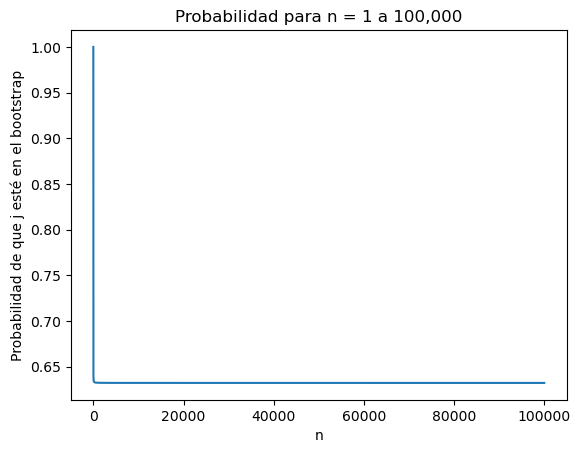

In [2]:
n = np.arange(1, 100001)  
p = 1 - (1 - 1/n)**n  # probabilidad de que j esté en el bootstrap

plt.plot(n, p)
plt.xlabel("n")
plt.ylabel("Probabilidad de que j esté en el bootstrap")
plt.title("Probabilidad para n = 1 a 100,000")
plt.show()


La gráfica muestra que, conforme el tamaño de *n* aumenta, la probabilidad de que una observación específica aparezca al menos una vez en un bootstrap sample se aproxima rápidamente a un valor cercano a 0.632. Esto significa que alrededor del 63% de las veces una observación estará presente en un bootstrap sample y alrededor del 37% de las veces quedará fuera. 

### h) Simulación para *n*=100 y *j*=4

In [3]:
n = 100           
j = 4             
B = 10000         

store = []

for _ in range(B):
    sample_bs = np.random.choice(np.arange(1, n+1), size=n, replace=True)
    store.append(j in sample_bs)

probabilidad = np.mean(store)

print(probabilidad)

0.631


El resultado de esta simulación muestra qué tan frecuentemente la observación número 4 aparece en un bootstrap sample de tamaño 100. Al repetir el proceso 10,000 veces, la proporción obtenida suele estar muy cerca de 0.63. Esto significa que, en promedio, una observación tiene alrededor de un 63% de probabilidad de aparecer al menos una vez en un bootstrap sample.

## 3.
### a) ¿Cómo se implementa k-fold cross-validation?

En k-fold cross-validation, primero se divide el conjunto de datos en k partes del mismo tamaño. Luego, se realiza el siguiente proceso k veces:

- 1. Seleccionas uno de los folds para usarlo como conjunto de prueba.

- 2. Entrenas el modelo usando los otros k − 1 folds.

- 3. Evalúas el modelo en el fold que quedó como prueba y guardas el error obtenido.

- 4. Repites este proceso cambiando cada vez cuál fold actúa como prueba, hasta que todos hayan sido usados.

Al final, se calcula el promedio de los k errores, y ese valor se toma como la estimación del error de test del modelo.

### b) Ventajas y desventajas de k-fold cross-validation

#### i. Comparado con el Validation Set Approach

**Ventajas de k-fold CV**

- Usa todos los datos para entrenar y para validar, mientras que el validation set solo usa una parte para entrenar.

- Produce estimaciones más estables y menos variables del error de test.

- Reduce el problema de que el resultado dependa demasiado de una sola división del dataset.

**Desventajas de k-fold CV**

- Es más costoso computacionalmente, porque se entrena el modelo k veces.

- Es más complejo de implementar que una única división train–test.

#### ii. Comparado con LOOCV (Leave-One-Out Cross-Validation)

**Ventajas de k-fold CV**

- Mucho más rápido que LOOCV, que entrena el modelo n veces.

- Suele producir una estimación con menor varianza, porque los folds son más grandes que una sola observación.

- Encuentra un mejor balance entre sesgo y varianza.

**Desventajas de k-fold CV**

- Tiene un poco más de sesgo que LOOCV, pues los modelos se entrenan con menos datos.

- Requiere elegir un valor de k.

## 4. ¿Cómo estimar la desviación estándar de una predicción hecha por un método de statistical learning?

- **1. Repetir el proceso de entrenamiento y predicción múltiples veces.**

Podemos usar bootstrap o k-folds. En cada repetición entrenamos el modelo en una muestra distinta del dataset y hacemos la predicción para el mismo valor específico de *X*.

- **2. Obtener un conjunto de predicciones.**

Después de repetir el procedimiento *B* veces, tendremos un conjunto de predicciones: $\hat{Y}_1, \hat{Y}_2, ..., \hat{Y}_B$.

- **3. Calcular la desviación estándar de esas predicciones.**

La variabilidad entre las predicciones refleja la incertidumbre del modelo. Así, la desviación estándar estimada es:

$
\hat{\sigma}_{\hat{Y}} = \sqrt{\frac{1}{B-1}\sum_{b=1}^{B}(\hat{Y}_b - \bar{Y})^2}
$

donde $\bar{Y}$ es el promedio de las predicciones.

Esta desviación estándar mide qué tanto podría variar la predicción del modelo si hubiéramos entrenado con datos ligeramente distintos. Representa la incertidumbre del modelo.

# Aplicado 

## 5.

### a) Predicción de 'Default' usando Regresión logística con las variables 'income' y 'balance' 

In [4]:
df = pd.read_csv("Default.csv").dropna()

y = df["default"].map({"No": 0, "Yes": 1})
X = df[["balance", "income"]]

Lr = LogisticRegression()
Lr.fit(X, y)

b0 = Lr.intercept_[0]
b = Lr.coef_[0]

print("Intercepto:", b0)
print("Coeficientes de balance e income:", b)

Intercepto: -11.540478115453409
Coeficientes de balance e income: [5.64710797e-03 2.08091985e-05]


### (b) Validación set approach: estimar el error de test

#### i. Split train/validation

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.5, random_state=1)

#### ii. Ajustar el modelo en el training set 

In [6]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

#### iii. Predecir en el validation set

In [7]:
probs = model.predict_proba(X_val)[:, 1]
y_pred = (probs > 0.5).astype(int)

#### iv. Calcular el validation error

In [8]:
val_error = 1 - accuracy_score(y_val, y_pred)
print(val_error)

0.032200000000000006


### c) Repetir el proceso con tres splits diferentes

In [9]:
errors = []

for seed in [1, 2, 3]:
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.5, random_state=seed
    )
    
    model = LogisticRegression()
    model.fit(X_train, y_train)

    probs = model.predict_proba(X_val)[:, 1]
    y_pred = (probs > 0.5).astype(int)

    errors.append(1 - accuracy_score(y_val, y_pred))

errors

[0.032200000000000006, 0.031200000000000006, 0.03400000000000003]

Los tres errores son similares pero no iguales, porque el validation set cambia cada vez. Esto muestra que el método es sensible a cómo se divide la muestra, y por eso pueden producir estimaciones variables del test error.

### d) Agregar la variable 'student'y repetir el proceso

In [10]:
df["student_dummy"] = df["student"].map({"No": 0, "Yes": 1})

X2 = df[["balance", "income", "student_dummy"]]

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X2, y, test_size=0.5, random_state=1
)

model2 = LogisticRegression()
model2.fit(X_train, y_train)

probs = model2.predict_proba(X_val)[:, 1]
y_pred = (probs > 0.5).astype(int)

val_error2 = 1 - accuracy_score(y_val, y_pred)
val_error2

0.032200000000000006

In [12]:
errors = []

for seed in [1, 2, 3]:
    X_train, X_val, y_train, y_val = train_test_split(
        X2, y, test_size=0.5, random_state=seed
    )
    
    model = LogisticRegression()
    model.fit(X_train, y_train)

    probs = model.predict_proba(X_val)[:, 1]
    y_pred = (probs > 0.5).astype(int)

    errors.append(1 - accuracy_score(y_val, y_pred))

errors

[0.032200000000000006, 0.03200000000000003, 0.03400000000000003]

La variable student no aporta información relevante para predecir default, por lo que incluirla no mejora el desempeño del modelo, y por eso los test errors son prácticamente iguales en los tres splits.

## 6.

### Estimación de errores estándar con logistic regression + bootstrap

### a) Obtener los errores estándar usando el modelo logístico normal

In [13]:
df2 = df[["default", "income", "balance"]].copy()
df2["default"] = df2["default"].map({"No": 0, "Yes": 1})
df2 = df2.dropna()

X = sm.add_constant(X)

model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Tue, 25 Nov 2025   Pseudo R-squ.:                  0.4594
Time:                        00:37:26   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0

In [14]:
print("\nErrores estándar:")
print(model.bse[["income", "balance"]])


Errores estándar:
income     0.000005
balance    0.000227
dtype: float64


### b) Función 'boot_fn()''

In [15]:
def boot_fn(data, index):
    sample = data.iloc[index]

    X = sample[["income", "balance"]]
    X = sm.add_constant(X)
    y = sample["default"]

    fit = sm.Logit(y, X).fit(disp=False)
    return fit.params[["income", "balance"]]

### c) Usar bootstrap para estimar los errores estándar

In [16]:
np.random.seed(1)
B = 1000   
boot_estimates = []

for _ in range(B):
    idx = np.random.choice(len(df2), len(df2), replace=True)
    boot_estimates.append(boot_fn(df2, idx))

boot_estimates = pd.DataFrame(boot_estimates)
boot_se = boot_estimates.std()

boot_se

income     0.000005
balance    0.000233
dtype: float64

Los errores estándar obtenidos son casi iguales, especialmente para 'income', lo que indica que este coeficiente es muy estable y tiene muy poca variabilidad. Para 'balance', el bootstrap produce un error estándar ligeramente mayor, lo cual es normal porque este método capta mejor la variación real entre muestras. En general, ambos métodos muestran que las estimaciones del modelo son precisas y consistentes.

## 7.
### a) Ajustar regresión logística usando Lag1 y Lag2

In [17]:
df = pd.read_csv("Weekly.csv").dropna()
df = df.dropna().reset_index(drop=True)

y = df["Direction"].map({"Down": 0, "Up": 1})
X = df[["Lag1", "Lag2"]]

Lr = LogisticRegression()
Lr.fit(X, y)

b0 = Lr.intercept_[0]
b = Lr.coef_[0]

print("Intercepto:", b0)
print("Coeficientes de Lag1 y Lag2:", b)

Intercepto: 0.22122502047138945
Coeficientes de Lag1 y Lag2: [-0.03869814  0.06020749]


### b) Ajustar regresión logística usando Lag1 y Lag2, usando todas las observaciones excepto la primera

In [18]:
df2 = df.iloc[1:]   

y = df2["Direction"].map({"Down": 0, "Up": 1})
X = df2[["Lag1", "Lag2"]]

Lr2 = LogisticRegression()
Lr2.fit(X, y)

b0 = Lr2.intercept_[0]
b = Lr2.coef_[0]

print("Intercepto (sin primera observación):", b0)
print("Coeficientes de Lag1 y Lag2:", b)

Intercepto (sin primera observación): 0.22324404116128674
Coeficientes de Lag1 y Lag2: [-0.03840931  0.06080633]


### c) Usar el modelo del punto (b) para predecir la dirección de la primera observación

In [19]:
prob_up = Lr2.predict_proba(df.iloc[[0]][["Lag1", "Lag2"]])[0][1]

pred = "Up" if prob_up > 0.5 else "Down"

# Valor real
real = df.iloc[0]["Direction"]

print("Probabilidad de Up:", prob_up)
print("Predicción:", pred)
print("Valor real:", real)
print("¿Correcta?", pred == real)


Probabilidad de Up: 0.5713814356939766
Predicción: Up
Valor real: Down
¿Correcta? False


### d) Cálculo del error LOOCV
#### i) Fit a logistic regression model using all but the i-th observation
#### ii) Compute the posterior probability of "Up" for the i-th observation
#### iii) Classify i using the posterior probability (threshold 0.5)
#### iv) Record whether an error was made (1 = error, 0 = correct)

In [20]:
y = df["Direction"].map({"Down": 0, "Up": 1})
X = df[["Lag1", "Lag2"]]

n = len(df)
errors = np.zeros(n)   

for i in range(n):
    # i) Ajustar el modelo con todas las observaciones excepto la i
    X_train = X.drop(i)
    y_train = y.drop(i)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    # ii) Probabilidad de que la observación i sea "Up"
    prob_up = model.predict_proba(X.iloc[[i]])[0][1]

    # iii) Clasificación según umbral 0.5
    pred = 1 if prob_up > 0.5 else 0

    # iv) Error = 1 si pred ≠ real
    errors[i] = 1 if pred != y.iloc[i] else 0

### e) Promedio de los errores = estimador LOOCV del test error

In [21]:
loocv_error = errors.mean()
print("LOOCV test error:", loocv_error)

LOOCV test error: 0.44995408631772266


El LOOCV error es menor de 0.5, lo que significa que el modelo basado solo en Lag1 y Lag2 no clasifica mucho mejor que adivinar al azar,

## 8.
### a) Generar datos 

In [22]:
np.random.seed(1)     

x = np.random.randn(100)
y = x - 2*(x**2) + np.random.randn(100)

df = pd.DataFrame({"x": x, "y": y})

df.head(3)

,x,y
0,1.624345,-4.099779
1,-0.611756,-0.135741
2,-0.528172,-0.682611


**¿Qué es *n*?**
Es el número de observaciones: n=100

**¿Qué es *p*?**
La variable predictora, x; p=1.

**Modelo para generar los datos**
El modelo en forma de ecuación es: $ y = x - 2x^2 + ε $ 

### b) Scatterplot de X contra Y

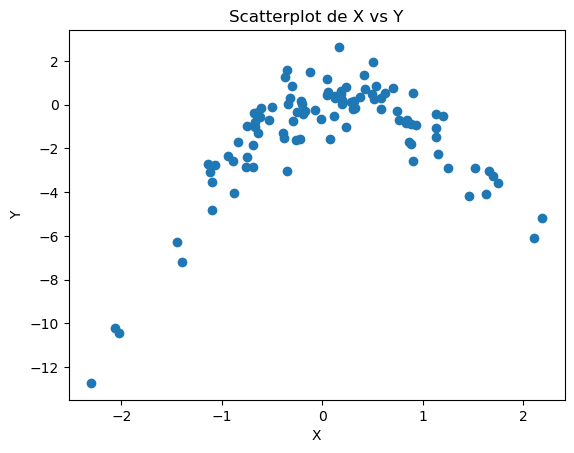

In [23]:
plt.scatter(x, y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatterplot de X vs Y")
plt.show()

La relación no es lineal. El gráfico muestra una parábola invertida, consistente con el modelo usado.

### c) LOOCV para los 4 modelos (polinomios de grado 1 a 4)

In [24]:
n = len(df)

def loocv_error(degree):
    errors = np.zeros(n)
    
    for i in range(n):
        X = np.column_stack([x**d for d in range(1, degree+1)])
        
        X_train = np.delete(X, i, axis=0)
        y_train = np.delete(y, i)
        
        model = LinearRegression().fit(X_train, y_train)
        
        y_pred = model.predict(X[i].reshape(1, -1))[0]
        
        errors[i] = (y[i] - y_pred)**2
    
    return errors.mean()

loocv_results = {
    "Grado 1": loocv_error(1),
    "Grado 2": loocv_error(2),
    "Grado 3": loocv_error(3),
    "Grado 4": loocv_error(4),
}

loocv_results

{'Grado 1': 6.260764331604616,
 'Grado 2': 0.9142897072803661,
 'Grado 3': 0.9268768781648805,
 'Grado 4': 0.8669116865881079}

El modelo lineal tiene un error muy alto porque no puede capturar la forma curva del modelo. Los modelos polinómicos (grados 2, 3 y 4) funcionan mucho mejor, y el de grado 4 obtiene el menor error, probablemente porque se adapta un poco más a las variaciones introducidas por el ruido.

In [25]:
# Nueva semilla
np.random.seed(42)

# Datos
x = np.random.randn(100)
y = x - 2*(x**2) + np.random.randn(100)

df = pd.DataFrame({"x": x, "y": y})
n = len(df)

def loocv_error(degree):
    errors = np.zeros(n)
    
    for i in range(n):
        X = np.column_stack([x**d for d in range(1, degree+1)])
        
        X_train = np.delete(X, i, axis=0)
        y_train = np.delete(y, i)
        
        model = LinearRegression().fit(X_train, y_train)
        
        y_pred = model.predict(X[i].reshape(1, -1))[0]
        
        errors[i] = (y[i] - y_pred)**2
    
    return errors.mean()

loocv_results = {
    "Grado 1": loocv_error(1),
    "Grado 2": loocv_error(2),
    "Grado 3": loocv_error(3),
    "Grado 4": loocv_error(4),
}

loocv_results

{'Grado 1': 5.3029566276895945,
 'Grado 2': 0.9127641950599259,
 'Grado 3': 0.9569572977749518,
 'Grado 4': 0.9727724672791457}

Al repetir el cálculo de los errores LOOCV con otra semilla aleatoria, los resultados no salen exactamente iguales a los del inciso (c). Esto ocurre porque los datos contienen un término de ruido aleatorio (rnorm(100)), y cambiar la semilla cambia ese ruido. Como el ruido afecta la relación entre X y Y, los errores LOOCV cambian ligeramente. Sin embargo, la tendencia general se mantiene: los modelos polinómicos de mayor grado siguen funcionando mejor que el lineal.

### e) Menor LOOCV error
El modelo con el menor LOOCV error fue el modelo de grado 2. Esto sí era esperado, porque los datos fueron generados usando exactamente un modelo cuadrático.

Por lo tanto, el modelo de grado 2 coincide con la forma real del proceso que generó los datos, y debería ajustarse mejor que los modelos demasiado simples (grado 1) o demasiado complejos (grados 3 y 4), que empiezan a sobreajustar el ruido.

## f) Significancia de los coeficientes y relación con los resultados de CV
Al ajustar los modelos por mínimos cuadrados:

- En el modelo de grado 1, el coeficiente lineal suele no ser estadísticamente significativo, porque la relación verdadera no es lineal.

- En el modelo de grado 2, los coeficientes de $X$ y $X^2$ normalmente sí resultan significativos, porque el modelo coincide con la verdadera forma de los datos.

- En los modelos de grado 3 y 4, los coeficientes adicionales (como $X^3$ Y $X^4$) suelen ser no significativos, ya que solo ajustan ruido y no aportan información real.

Estos resultados coinciden con lo que hallamos mediante validación cruzada: el mejor modelo es el cuadrático. Es el único en el que las variables clave resultan significativas, mientras que los términos extra de los modelos más complejos no aportan valor real.

## 9.
### a) Estimar la media poblacional de medv ($\hat{μ̂}$)

In [26]:
df = pd.read_excel("Boston Housing Dataset 1978.xlsx")
df.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7


In [27]:
mu_hat = df["MEDV"].mean()
mu_hat

23.750442477876106

### b) Estimar el error estándar de μ̂ usando la fórmula clásica

In [28]:
std = df["MEDV"].std()
n = len(df)

se_formula = std / np.sqrt(n)
se_formula

0.3915901080014807

El error estándar indica qué tan precisa es nuestra estimación de la media. Un SE pequeño significa que la media muestral es una buena aproximación de la media poblacional real.

### c) Estimar el error estándar usando bootstrap

In [29]:
B = 1000
boot_means = []

for _ in range(B):
    sample = resample(df["MEDV"])
    boot_means.append(sample.mean())

se_bootstrap = np.std(boot_means)
se_bootstrap

0.4101916044914577

Los dos métodos dan números muy parecidos, así que la media está bien estimada. El bootstrap da un error un poco más grande, lo cual es normal porque este método no asume ninguna forma específica de la distribución y suele capturar un poco más de variabilidad.

### d) Intervalo de confianza para la media 

In [30]:
# Con Bootstrap
CI_boot = (mu_hat - 2*se_bootstrap, mu_hat + 2*se_bootstrap)
CI_boot

(22.930059268893192, 24.57082568685902)

In [31]:
# Con 't.test'
data = df["MEDV"].dropna()

CI_ttest = stats.t.interval(confidence=0.95,df=len(data)-1,loc=np.mean(data),scale=stats.sem(data))

print("IC t-test:", CI_ttest)

IC t-test: (22.936201626581155, 24.564683329171057)


El intervalo bootstrap va de 22.89 a 24.61, mientras que el del t-test va de 22.94 a 24.56. Esto significa que ambos métodos coinciden en que el valor promedio real de MEDV probablemente está entre 23 y 25 mil dólares aproximadamente.

### e) Estimar la mediana poblacional de medv

In [32]:
median_medv = df["MEDV"].median()
median_medv

21.95

### f) Bootstrap para estimar el error estándar de la mediana

In [33]:
B = 1000
boot_medians = []

for _ in range(B):
    sample = df["MEDV"].sample(len(df), replace=True)
    boot_medians.append(sample.median())

boot_se_median = np.std(boot_medians)
boot_se_median

0.298301592352438

La mediana es bastante estable, porque su variación típica entre muestras es de solo alrededor de 0.31. Esto indica que la estimación de la mediana es confiable y no se mueve mucho incluso si los datos cambian un poco.

### g) Estimar el percentil 10 de MEDV

In [34]:
p10_medv = df["MEDV"].quantile(0.10)
p10_medv

14.5

### h) Bootstrap para el error estándar del percentil 10

In [35]:
boot_p10 = []

for _ in range(B):
    sample = df["MEDV"].sample(len(df), replace=True)
    boot_p10.append(sample.quantile(0.10))

boot_se_p10 = np.std(boot_p10)
boot_se_p10

0.3919521088092268

El error estándar del percentil 10 (~0.40) significa que la cifra que representa a las casas más baratas puede cambiar más o menos 0.4 unidades si tomáramos otras muestras parecidas. La estimación es razonable, pero tiene algo de variación natural porque estamos mirando la parte baja de los precios.